In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Portugues/modelo_fakenews_final.zip" -d "/content/modelo_fakenews_final"

Archive:  /content/drive/MyDrive/Portugues/modelo_fakenews_final.zip
   creating: /content/modelo_fakenews_final/modelo_fakenews_final/
   creating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/config.json  
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/model.safetensors  
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/optimizer.pt  
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/rng_state.pth  
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/scheduler.pt  
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/special_tokens_map.json  
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/tokenizer.json  
  inflating: /content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450/to

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

modelo_dir = "/content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450"

# Carrega o tokenizer
tokenizer = AutoTokenizer.from_pretrained(modelo_dir, model_type="bert")

# Carrega o modelo treinado
model = AutoModelForSequenceClassification.from_pretrained(modelo_dir)

# Coloca em modo de avaliação
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

<>:51: SyntaxWarning: invalid escape sequence '\ '
<>:51: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2146435152.py:51: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Total de erros: {len(erros)} de {len(df_test)} amostras")


🔄 Rodando predições em lotes...

 Acurácia: 0.9903

 Relatório de Classificação:
              precision    recall  f1-score   support

        FAKE       0.99      0.99      0.99      1489
        REAL       0.99      0.99      0.99      1490

    accuracy                           0.99      2979
   macro avg       0.99      0.99      0.99      2979
weighted avg       0.99      0.99      0.99      2979

\ Total de erros: 29 de 2979 amostras


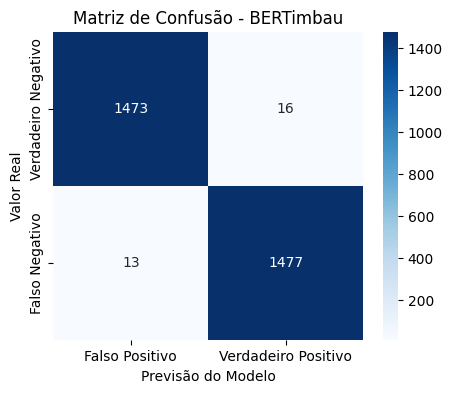

Arquivo de predições salvo em: /content/drive/MyDrive/Portugues/resultados_bert.csv


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


modelo_dir = "/content/modelo_fakenews_final/modelo_fakenews_final/checkpoint-7450"
csv_path = "/content/drive/MyDrive/Portugues/test_dataset.csv"

# Define o dispositivo de execução GPU (cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carrega o tokenizer e o modelo
tokenizer = AutoTokenizer.from_pretrained(modelo_dir, model_type="bert")
model = AutoModelForSequenceClassification.from_pretrained(modelo_dir).to(device)
model.eval()  #modo de avaliação

# Lê o dataset de teste
df_test = pd.read_csv(csv_path, sep=";", encoding="utf-8")

# F faz previsões em lotes p evitar sobrecarga de memória
def predict_in_batches(texts, batch_size=200):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        # Desativa o cálculo  gradiente e gera previsões
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    return preds


print("Gerando predições")
preds = predict_in_batches(df_test["texto"].tolist(), batch_size=200)

# Calcula métricas de desempenho
y_true = df_test["label"].values
print("\nAcurácia:", round(accuracy_score(y_true, preds), 4))
print("\nRelatório de Classificação:")
print(classification_report(y_true, preds, target_names=["FAKE", "REAL"]))

# Identifica e mostra as amostras que o modelo errou
df_test["predito"] = preds
erros = df_test[df_test["predito"] != df_test["label"]]
print(f"\nTotal de erros: {len(erros)} de {len(df_test)} amostras")

# Cria uma matriz de confusão
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Falso Positivo", "Verdadeiro Positivo"],
            yticklabels=["Verdadeiro Negativo", "Falso Negativo"])
plt.title("Matriz de Confusão - BERTimbau")
plt.xlabel("Previsão do Modelo")
plt.ylabel("Valor Real")
plt.show()

# Salva as predições completas
output_path = "/content/drive/MyDrive/Portugues/resultados_bert.csv"
df_test.to_csv(output_path, sep=";", index=False, encoding="utf-8-sig")
print(f"Arquivo de predições salvo em: {output_path}")
